# 为训练过程添加额外的功能和优化

In [1]:
from importlib.metadata import version
import torch

print("torch version:", version("torch"))

torch version: 2.6.0+cu126


In [2]:
# 使用sys.path添加上级目录
import sys
import os
package_path = os.path.dirname(os.path.dirname(os.getcwd()))
file_path = os.path.join(package_path, "appendix-D", "01_main-chapter-code")
print(file_path)
sys.path.append(file_path)

f:\project\LLMs-from-scratch-CN\appendix-D\01_main-chapter-code


In [3]:
if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

print(f"Using {device} device.")

Using cuda device.


In [4]:
from previous_chapters import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # 词汇表大小
    "context_length": 256, # 缩短的上下文长度 （原始长度:1024）
    "emb_dim": 768,        # 嵌入维度
    "n_heads": 12,         # 注意力头的数量
    "n_layers": 12,        # 层数
    "drop_rate": 0.1,      # Dropout 比率
    "qkv_bias": False      # 查询-键-值偏置
}

torch.manual_seed(123)

# 初始化模型
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [5]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [6]:
from previous_chapters import create_dataloader_v1

# 划分训练集、验证集
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    text_data[:split_idx],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    text_data[split_idx:],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

## D.1 学习率预热

In [7]:
# 迭代epochs
n_epochs = 15
# 初始学习率
initial_lr = 0.0001
# 峰值学习率
peak_lr = 0.01

In [10]:
# 将预热步数的占比设置为20%
total_steps = len(train_loader) * n_epochs
warmup_steps = int(0.2 * total_steps)
print(warmup_steps)

# 预热时的学习率增量
lr_increment = (peak_lr - initial_lr) / warmup_steps
print(lr_increment)


27
0.00036666666666666667


In [11]:
global_step = -1
track_lrs = []

optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1

        # 学习率预热
        if global_step < warmup_steps:
            lr = initial_lr + global_step * lr_increment
        else:
            lr = peak_lr
        
        # 更新学习率
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        # 跟踪学习率
        track_lrs.append(optimizer.param_groups[0]["lr"])
        
        # 计算损失和更新权重
        # ...


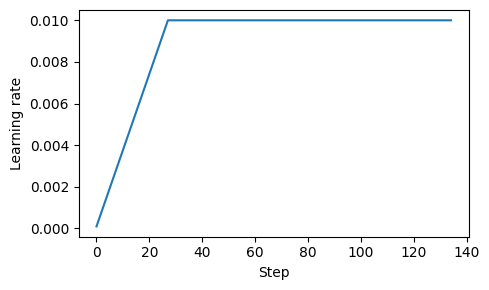

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.ylabel("Learning rate")
plt.xlabel("Step")
total_training_steps = len(train_loader) * n_epochs
plt.plot(range(total_training_steps), track_lrs)
plt.tight_layout()
plt.savefig("1.pdf")
plt.show()

## D.2 余弦衰减